In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [5]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [6]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [7]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [8]:
trn_list, val_list, tst_list = [AudioItemList.from_df(df, path=NSYNTH_AUDIO, 
                                                      folder=folder, suffix='.wav')
                                for df, folder in zip([trn_df, val_df, tst_df], 
                                                      ['train', 'valid', 'test'])]
len(trn_list), len(val_list), len(tst_list)

(16915, 1112, 347)

In [9]:
def get_frame(x):
    start = 1024
    frame_len = 1024
    return x[start:start+frame_len]

In [10]:
tfm_list = [get_frame]
tfms = (tfm_list, tfm_list) # train, valid tfms 

n_fft = 512 
n_hop = 256
n_mels = 64
sample_rate = 16000
ref = 'max'
top_db = 50.0
bs = 32

data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .add_test(tst_list)
            .transform(tfms)
            .databunch(bs=bs))
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([32, 1024]), torch.Size([32]), tensor(-0.9431), tensor(0.8806))

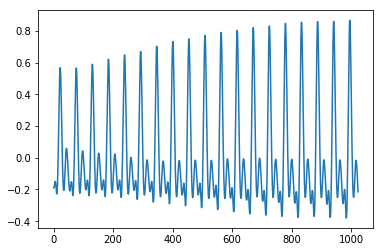

In [11]:
plt.plot(xs[0])

In [28]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(1024, 1024, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(1024, 1024, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [29]:
model = SimpleModel(data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________________
Linear               [32, 1024]           1049600    True      
______________________________________________________________________
ReLU                 [32, 1024]           0          False     
______________________________________________________________________
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________________
Linear               [32, 1024]           1049600    True      
______________________________________________________________________
ReLU                 [32, 1024]           0          False     
______________________________________________________________________
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________

In [30]:
model_name = 'pitch_frame_v1'

In [32]:
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,1.443006,0.967086,0.699640
2,0.971300,0.526067,0.841727
3,0.628546,0.309439,0.905576
4,0.452133,0.259925,0.933453


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


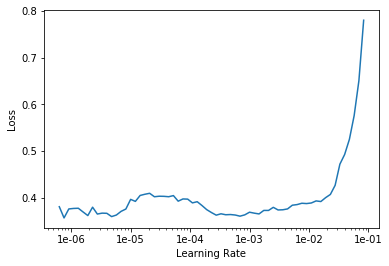

In [33]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.400889,0.263282,0.928957
2,0.442472,0.257180,0.935252
3,0.457962,0.277619,0.915468
4,0.395424,0.252805,0.937050
5,0.367824,0.299578,0.930755
6,0.333997,0.393432,0.933453
7,0.277045,0.283054,0.940647
8,0.268278,0.225324,0.941547


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


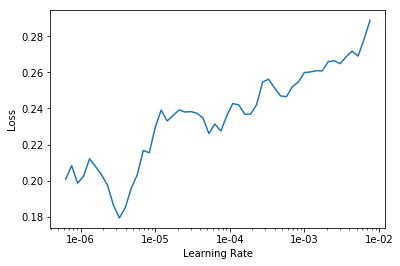

In [35]:
learn.load(model_name + '-stage-2')
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,accuracy
1,0.270184,0.193134,0.942446
2,0.330807,0.293574,0.927158
3,0.373291,0.279860,0.922662
4,0.365863,0.251680,0.922662
5,0.329138,0.261965,0.927158
6,0.289301,0.219997,0.939748
7,0.227385,0.238644,0.934353
8,0.239418,0.235143,0.934353


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


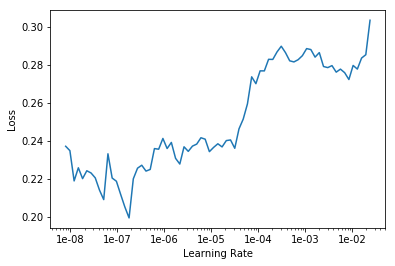

In [37]:
learn.load(model_name + '-stage-3')
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [38]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=1e-4)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy
1,0.253036,0.220152,0.938849
2,0.257396,0.227468,0.935252
3,0.220307,0.208516,0.941547
4,0.212171,0.213951,0.944245
5,0.220346,0.235108,0.943345
6,0.233779,0.219961,0.942446
7,0.232551,0.209972,0.942446
8,0.238671,0.228373,0.937950


In [39]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=1e-5)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy
1,0.242137,0.261553,0.934353
2,0.230196,0.223296,0.937050
3,0.241398,0.224151,0.941547
4,0.256980,0.237162,0.942446
5,0.253771,0.224767,0.937050
6,0.221422,0.227112,0.940647
7,0.242272,0.218586,0.939748
8,0.224735,0.234204,0.936151


In [15]:
learn.load(model_name + '-stage-4');

In [18]:
def preds_stats(learner):
    trn_accuracy = float(accuracy(*learner.get_preds(DatasetType.Train)))
    trn_error_rate = 1 - trn_accuracy
    trn_errors = round(len(learner.data.train_ds) * trn_error_rate)
    
    val_accuracy = float(accuracy(*learner.get_preds(DatasetType.Valid)))
    val_error_rate = 1 - val_accuracy
    val_errors = round(len(learner.data.valid_ds) * val_error_rate)
    
    print("Train\n-----")
    print("  accuracy:   {:.4f}".format(trn_accuracy))
    print("  num_errors: {}".format(trn_errors))
    
    
    print("Valid\n-----")
    print("  accuracy:   {:.4f}".format(val_accuracy))
    print("  num_errors: {}".format(val_errors))
    
preds_stats(learn)

Train
-----
  accuracy:   0.9579
  num_errors: 713
Valid
-----
  accuracy:   0.9748
  num_errors: 28


In [20]:
n_errors = round(float(1 - accuracy(*learn.get_preds(DatasetType.Train))) * len(trn_list))
print(n_errors, 'errors')

714 errors


In [19]:
interp = learn.interpret()

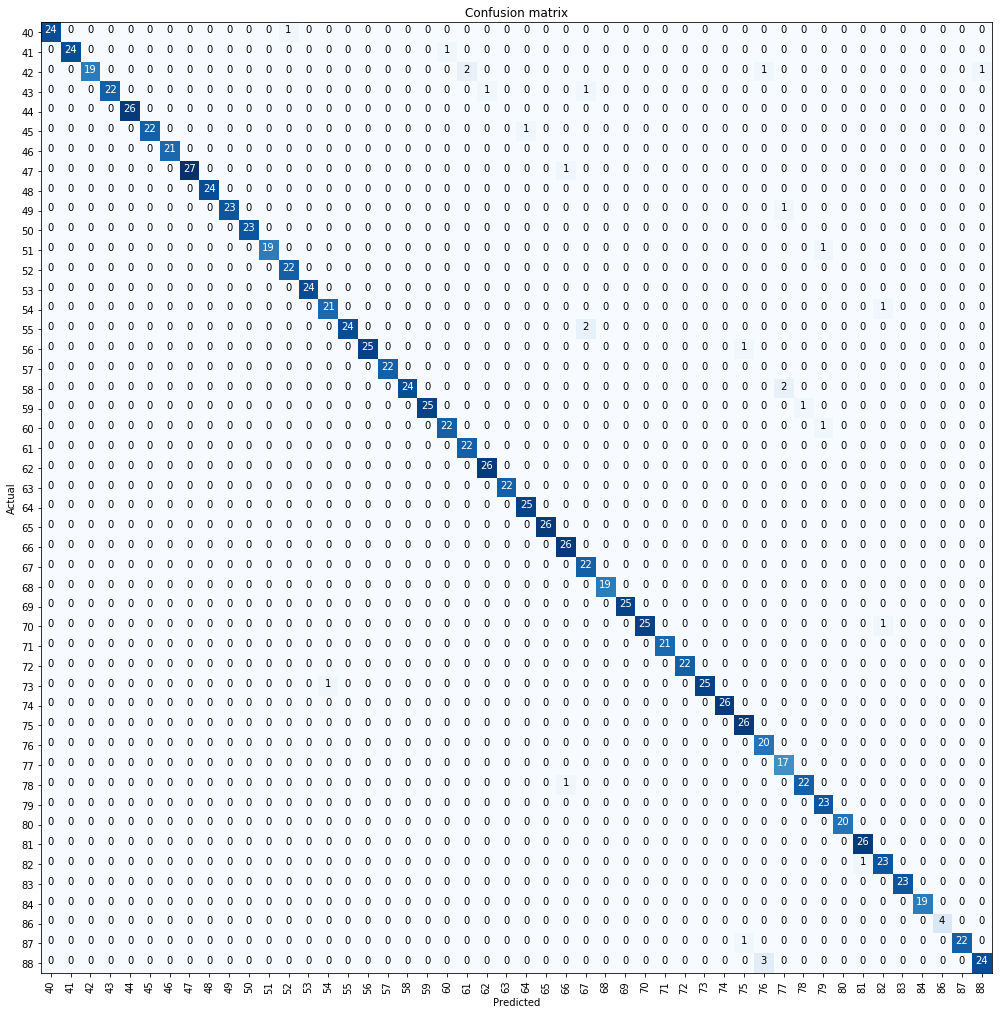

In [27]:
interp = learn.interpret()
interp.plot_confusion_matrix(figsize=(14, 14))